## Acknowledgements
Portions of the code, analysis, and insights were developed with assistance from OpenAI's ChatGPT.


# 1. Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



## 1.1 Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.


## 1.2 Loading Libraries

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm  # Use this for Jupyter

# Data Preprocessing and Transformation
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector

# Model Selection and Tuning
from sklearn.model_selection import GridSearchCV, train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.metrics import precision_recall_curve

# 2. Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

## 2.1 How many marketing campaigns does this data represent?

The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. 

During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. For each contact, a large number of attributes was stored and if there was a success (the target variable). For the whole database considered, there were 6499 successes (8% success rate).

# 3. Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


# 4. Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



## 4.1 Feature data types

The following provides details on each feature of the data set

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## 4.2 Features needing to be coerced to a different data type

The following provides details on features that will need to be encoded before analysis

In [6]:
# Select columns with non-numerical data types (object or category)
non_numeric_features = df.select_dtypes(include=['object', 'category']).columns
print("These Non-numeric features will need to be coerced to a different data type:")
print(non_numeric_features)

These Non-numeric features will need to be coerced to a different data type:
Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')


## 4.2 Missing Data Check

The following will provide details on missing data that will need to be dealt before analysis.

In [7]:
# Check how many rows contain at least one missing value
rows_with_missing = df.isnull().any(axis=1).sum()
print(f"Number of rows with missing values: {rows_with_missing}")


Number of rows with missing values: 0


## 4.3 Vizualize features against "y" feature

The following graphs plot each feature against "y" to help provide some knowledge of the dataset.

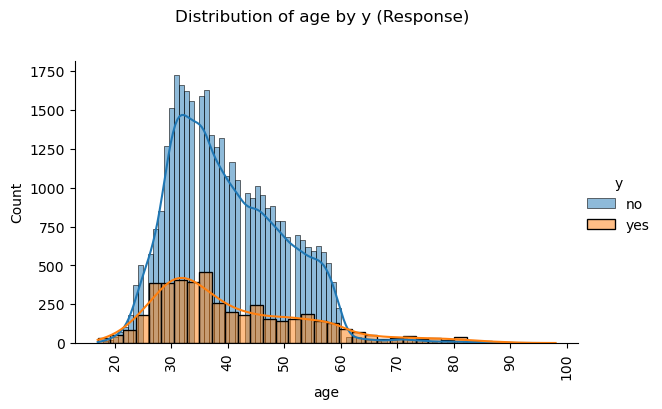

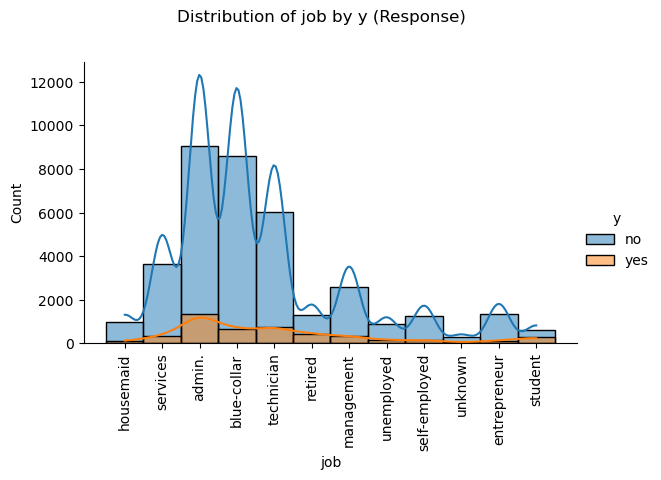

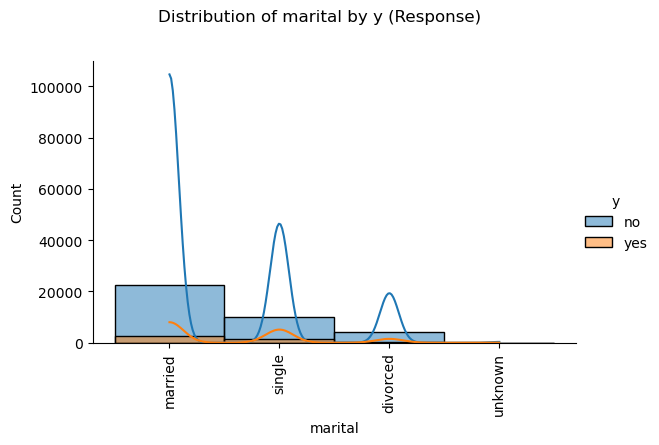

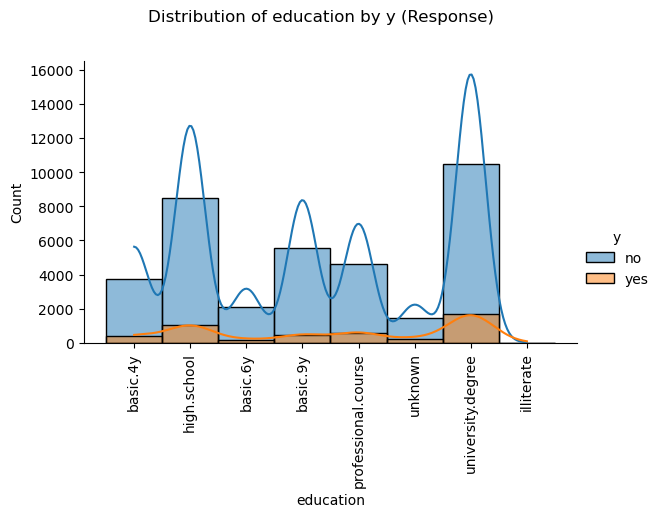

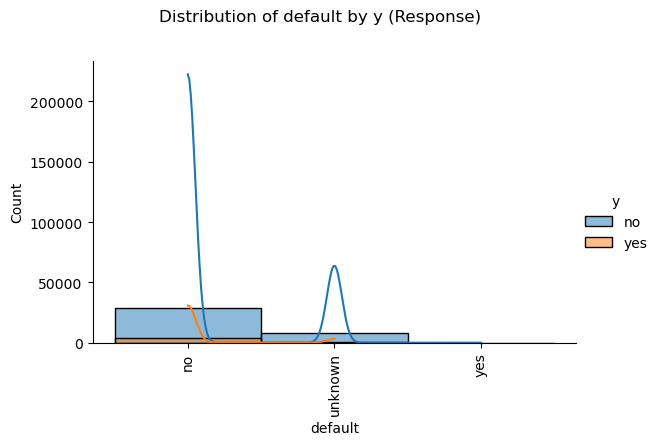

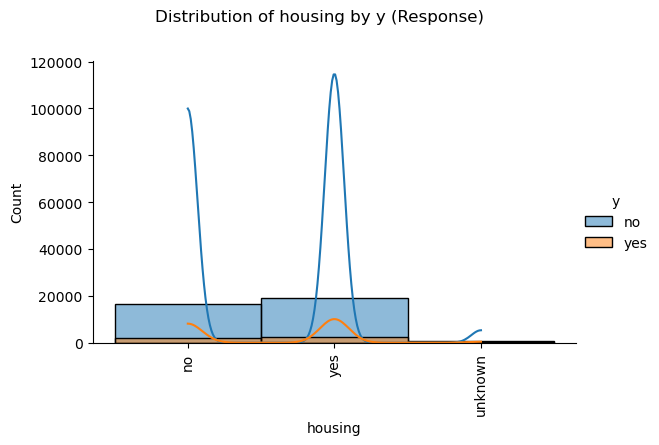

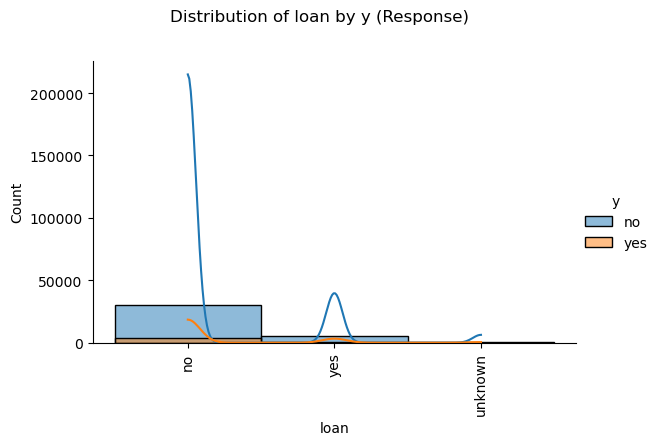

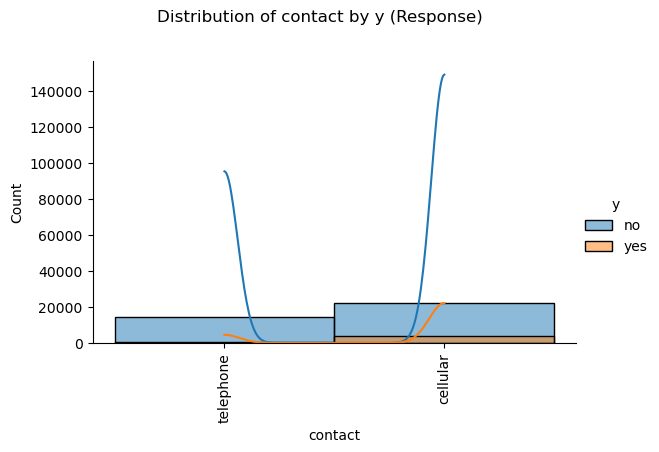

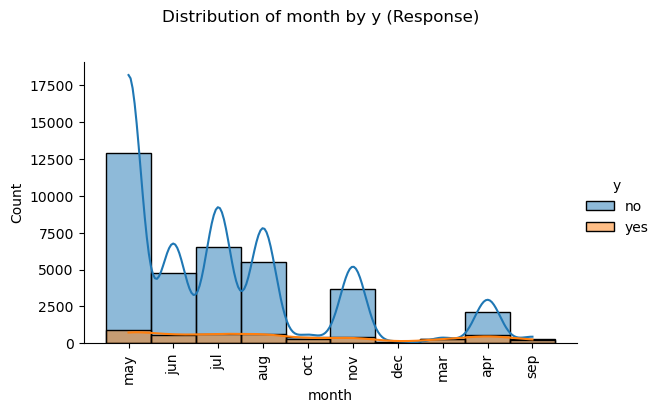

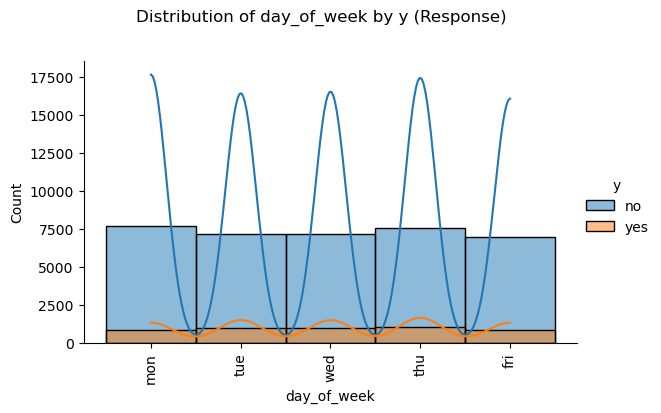

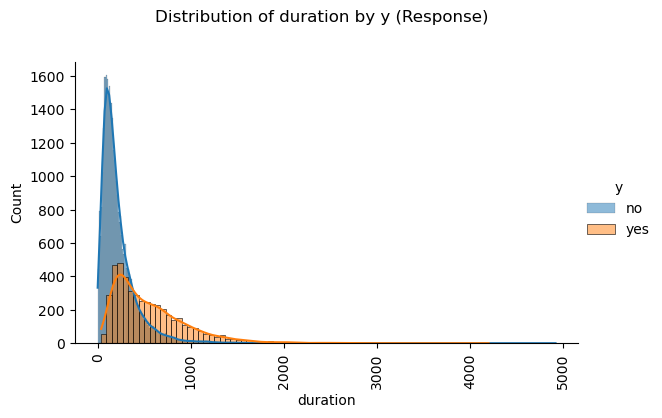

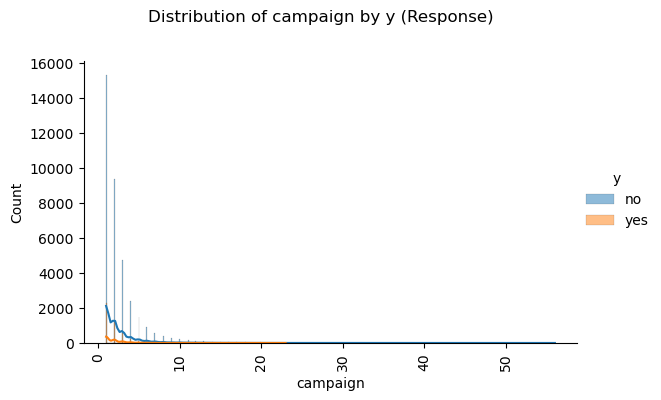

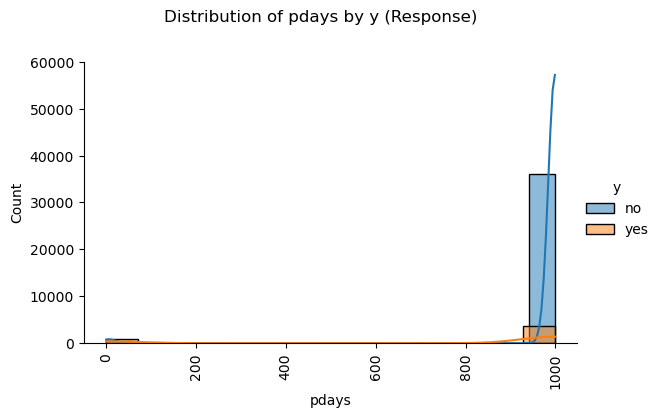

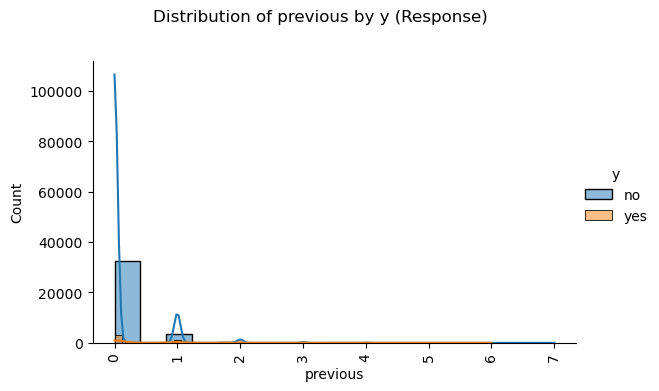

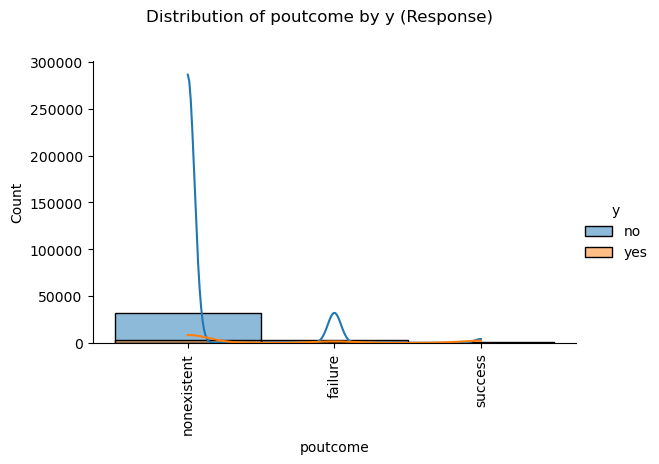

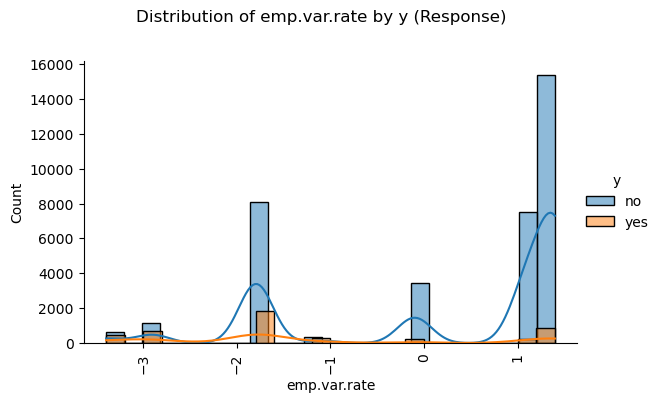

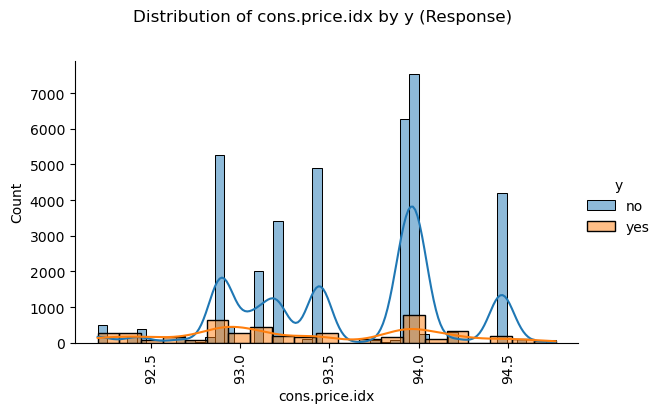

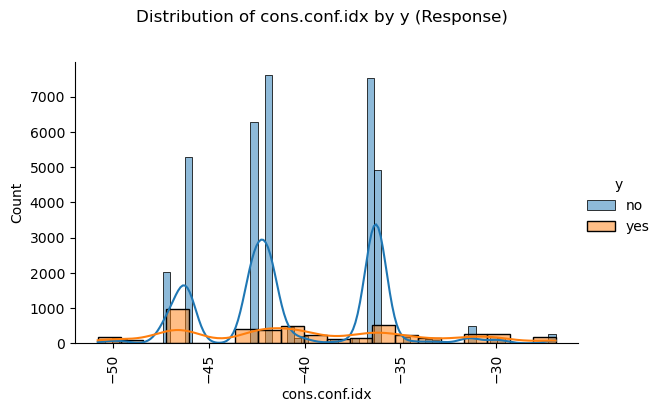

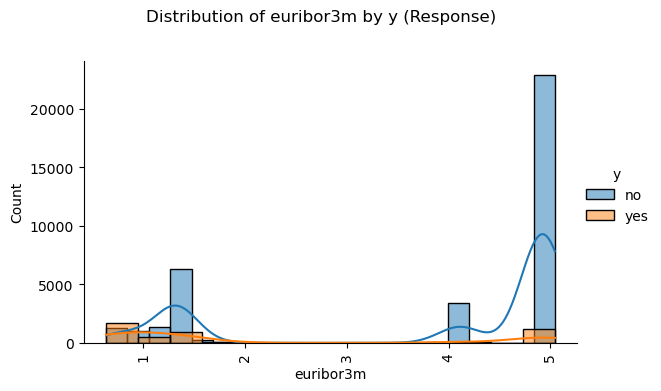

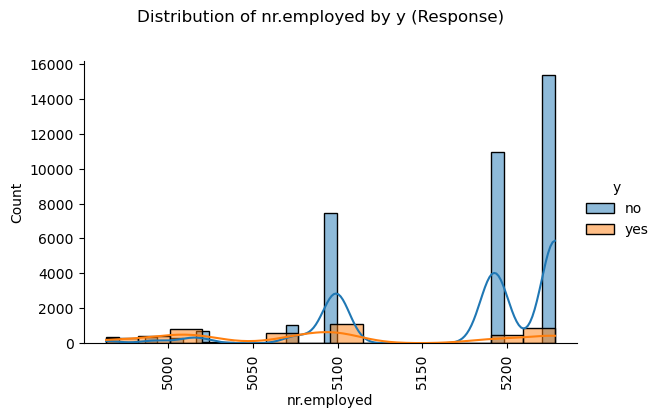

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all feature columns except 'y'
features_to_plot = [col for col in df.columns if col != 'y']

# Loop through all features to generate plots
for feature in features_to_plot:
    # Initialize FacetGrid with hue='y' to differentiate target classes
    g = sns.FacetGrid(df, hue='y', height=4, aspect=1.5)
    g.map(sns.histplot, feature, kde=True).add_legend()

    # Adjust the layout, set title, and rotate x-tick labels
    plt.subplots_adjust(top=0.85)
    g.fig.suptitle(f'Distribution of {feature} by y (Response)')
    plt.xticks(rotation=90)  # Rotate x-tick labels by 45 degrees

    # Display the plot
    plt.show()

# 5. Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

## 5.1 Business Objective

The business problem involves improving the efficiency of bank marketing campaigns to increase customer subscriptions to long-term deposit products. Specifically, the bank wants to:

- Reduce the number of unsuccessful contacts: Each contact requires resources such as time, human effort, and communication channels. Contacting customers unlikely to subscribe is costly and inefficient.

- Target customers more likely to subscribe: By predicting which customers are more inclined to subscribe, the bank can focus efforts on high-probability leads, thereby improving the campaign's return on investment (ROI).

- Maintain or increase the subscription success rate: Despite contacting fewer customers, the goal is to achieve the same or higher success rates.

- Optimize campaign resources: This includes reducing call center workload, optimizing call times, and enhancing communication strategies.

The classification models—KNN, Logistic Regression, Decision Trees, and SVM—are being compared to determine which can best predict customer behavior (whether a customer will subscribe). The outcome will help the bank improve targeting, reduce costs, and allocate resources efficiently, ultimately increasing campaign success and customer engagement.

# 6. Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

## 6.1 Dealing with missing data

In [9]:
# Display Initial Data Overview
print("Initial Data Overview:")
print(df.head())

# Identify and Handle Missing Data
print("\nChecking for Missing Data:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Impute missing data: Categorical features with the most frequent value
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Impute missing data: Numerical features with the median
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

print("\nMissing data handled. Verifying:")
print(f"{df.isnull().sum().sum()} missing values remaining.")


Initial Data Overview:
   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx 

## 6.2 Dealing with outliers


Outliers have been capped. Plotting box plots to confirm:


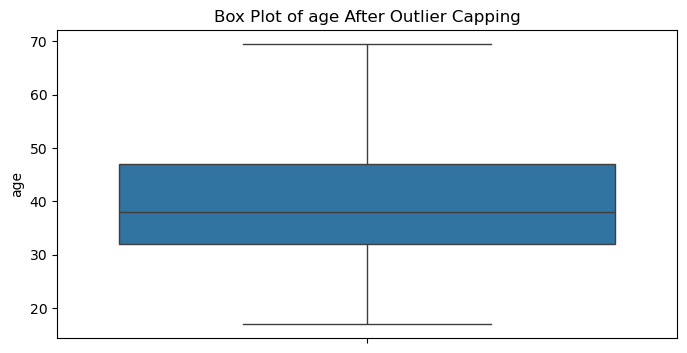

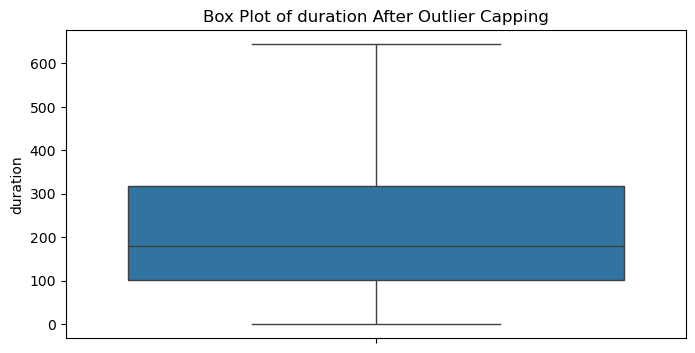

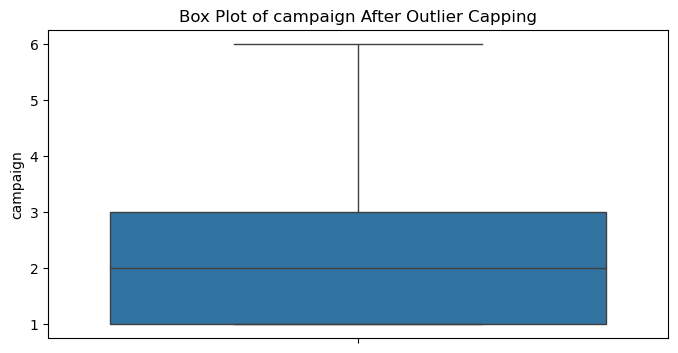

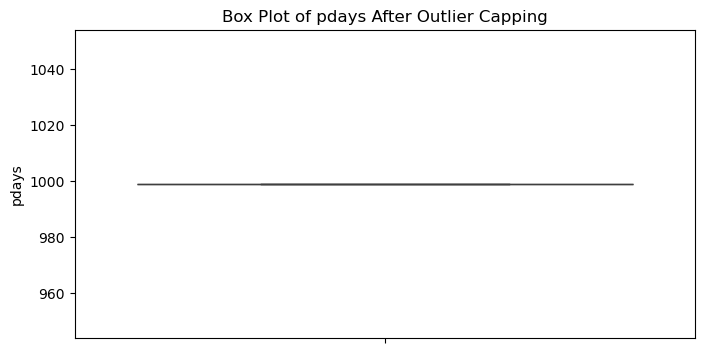

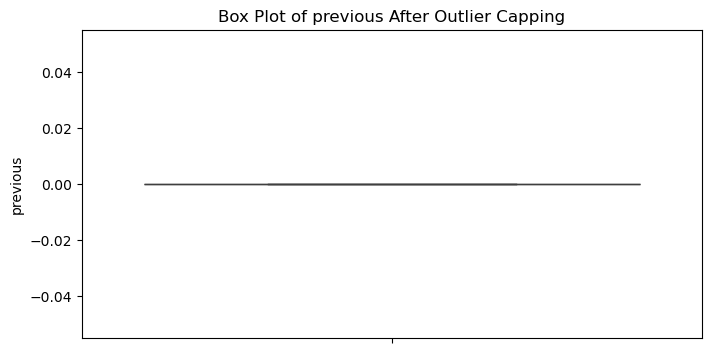

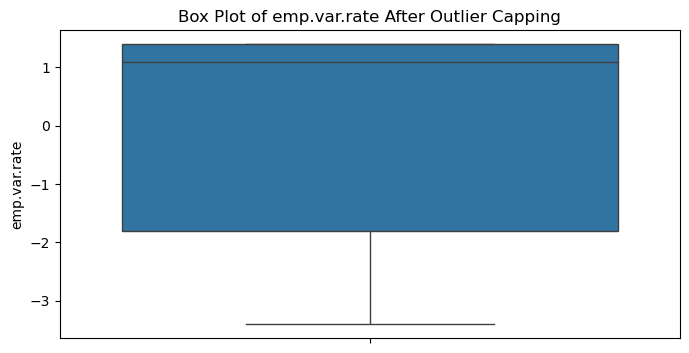

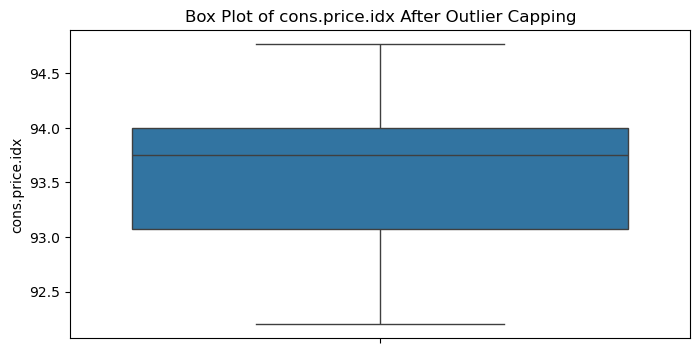

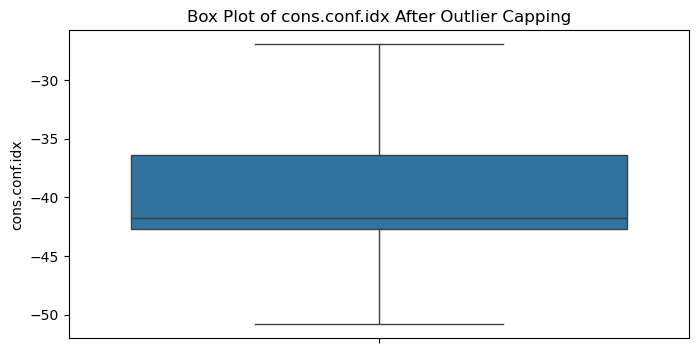

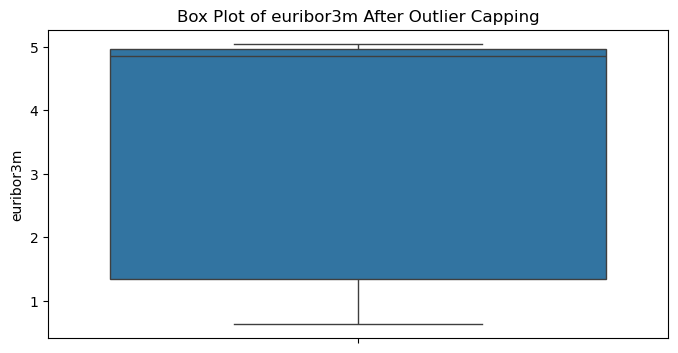

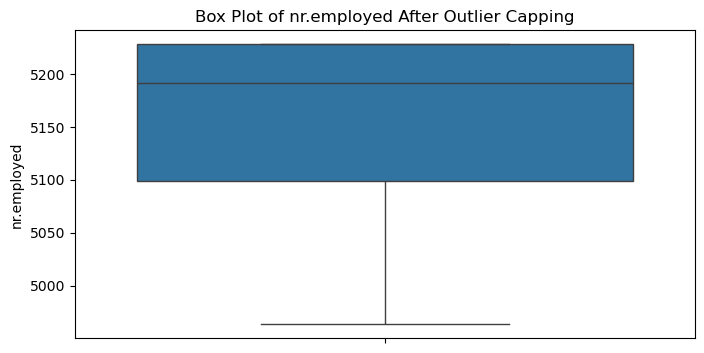

In [10]:
# Detect and Cap Outliers using IQR Method
def detect_and_cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers at the IQR boundaries
    data[column] = np.clip(data[column], lower_bound, upper_bound)

# Apply outlier capping to numerical columns
for col in numerical_cols:
    detect_and_cap_outliers(df, col)

print("\nOutliers have been capped. Plotting box plots to confirm:")
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(df[col])
    plt.title(f'Box Plot of {col} After Outlier Capping')
    plt.show()

## 6.3 Dealing with non-numerical data

In [11]:
# One-Hot Encode Categorical Features
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Updated to use 'sparse_output'
encoded_features = encoder.fit_transform(df[categorical_cols])

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate Encoded Features with the Original Data
df_numeric = df.drop(columns=categorical_cols)  # Drop original categorical columns
df_encoded = pd.concat([df_numeric, encoded_df], axis=1)

print("\nAll categorical features have been encoded. Verifying:")
print(df_encoded.head())


All categorical features have been encoded. Verifying:
    age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0  56.0     261.0         1    999         0           1.1          93.994   
1  57.0     149.0         1    999         0           1.1          93.994   
2  37.0     226.0         1    999         0           1.1          93.994   
3  40.0     151.0         1    999         0           1.1          93.994   
4  56.0     307.0         1    999         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  ...  month_nov  month_oct  \
0          -36.4      4.857       5191.0  ...        0.0        0.0   
1          -36.4      4.857       5191.0  ...        0.0        0.0   
2          -36.4      4.857       5191.0  ...        0.0        0.0   
3          -36.4      4.857       5191.0  ...        0.0        0.0   
4          -36.4      4.857       5191.0  ...        0.0        0.0   

   month_sep  day_of_week_mon  day_of_week_thu  

## 6.4 Dealing with correlated data


Highly correlated features to remove: ['euribor3m', 'nr.employed', 'loan_unknown']


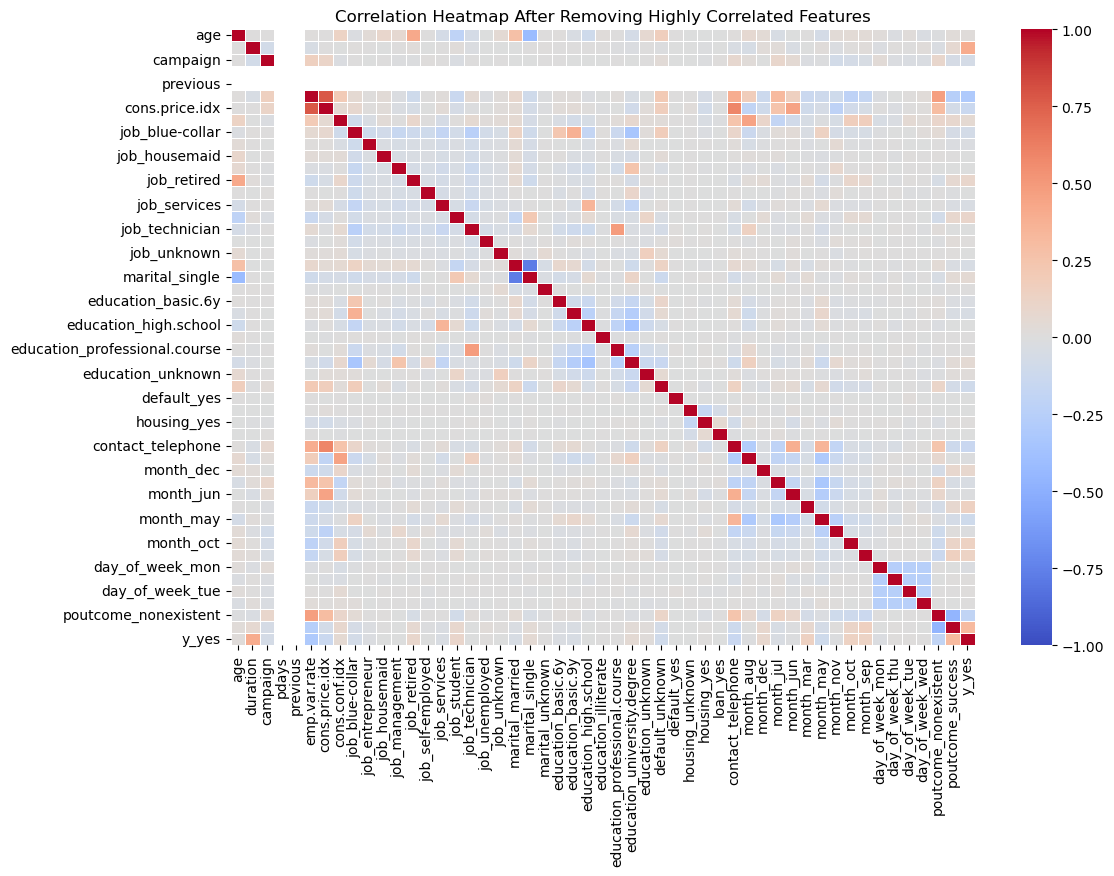

In [12]:
# Identify and Handle Highly Correlated Features
correlation_matrix = df_encoded.corr().abs()
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
upper_corr_matrix = correlation_matrix.where(upper_triangle)

# Identify highly correlated features (threshold > 0.85)
high_corr_features = [
    column for column in upper_corr_matrix.columns if any(upper_corr_matrix[column] > 0.85)
]
print(f"\nHighly correlated features to remove: {high_corr_features}")

# Drop highly correlated features from the DataFrame
df_cleaned = df_encoded.drop(columns=high_corr_features)

# Verify and Visualize the Remaining Numerical Features
remaining_corr_matrix = df_cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    remaining_corr_matrix, 
    annot=False,  # Set to False to remove values from the heatmap
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    linewidths=0.5
)
plt.title('Correlation Heatmap After Removing Highly Correlated Features')
plt.show()

## 6.5 Cleaned data set

In [13]:
# Final Overview of the Cleaned DataFrame
print("\nFinal Cleaned Data Overview:")
print(df_cleaned.head())
print(f"Data Shape After Cleaning: {df_cleaned.shape}")

# Save the cleaned DataFrame to a CSV file
df_cleaned.to_csv('df_cleaned.csv', index=False)

print("Cleaned DataFrame saved as 'df_cleaned.csv'.")


Final Cleaned Data Overview:
    age  duration  campaign  pdays  previous  emp.var.rate  cons.price.idx  \
0  56.0     261.0         1    999         0           1.1          93.994   
1  57.0     149.0         1    999         0           1.1          93.994   
2  37.0     226.0         1    999         0           1.1          93.994   
3  40.0     151.0         1    999         0           1.1          93.994   
4  56.0     307.0         1    999         0           1.1          93.994   

   cons.conf.idx  job_blue-collar  job_entrepreneur  ...  month_nov  \
0          -36.4              0.0               0.0  ...        0.0   
1          -36.4              0.0               0.0  ...        0.0   
2          -36.4              0.0               0.0  ...        0.0   
3          -36.4              0.0               0.0  ...        0.0   
4          -36.4              0.0               0.0  ...        0.0   

   month_oct  month_sep  day_of_week_mon  day_of_week_thu  day_of_week_tue

# 7. Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [14]:
# List all columns to identify the correct target column name
print("Columns in the DataFrame:")
print(df_cleaned.columns)

Columns in the DataFrame:
Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'education_unknown', 'default_unknown', 'default_yes',
       'housing_unknown', 'housing_yes', 'loan_yes', 'contact_telephone',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success', 'y_yes'],

In [15]:

# Define Features and Target Variable
X = df_cleaned.drop('y_yes', axis=1)  # Features
y = df_cleaned['y_yes']  # Target

# Perform Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Initialize the Scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

# Verify the shapes of the scaled datasets
print(f"Scaled Training Set Shape: {X_train_scaled.shape}")
print(f"Scaled Test Set Shape: {X_test_scaled.shape}")

# Check target distribution in both sets (Optional)
print("\nTarget Distribution in Training Set:")
print(y_train.value_counts(normalize=True))

print("\nTarget Distribution in Test Set:")
print(y_test.value_counts(normalize=True))



Scaled Training Set Shape: (28831, 50)
Scaled Test Set Shape: (12357, 50)

Target Distribution in Training Set:
y_yes
0.0    0.887343
1.0    0.112657
Name: proportion, dtype: float64

Target Distribution in Test Set:
y_yes
0.0    0.887351
1.0    0.112649
Name: proportion, dtype: float64


# 8. Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

## 8.1 The following Github repository inspired the following code for creating a baseline model

### Acknowledgement
https://github.com/preethi-prak/ML_Classification/blob/16970d5a52f3f4298ba05ca9f9d3e12082267c8b/Baseline_Classfier.ipynb


In [16]:

strategies = ['stratified', 'most_frequent', 'uniform', 'prior']

for strategy in strategies:
    print(f"\nTesting strategy: {strategy}")
    
    # Create and train the DummyClassifier with the chosen strategy
    dummy_clf = DummyClassifier(strategy=strategy, random_state=42)
    dummy_clf.fit(X_train_scaled, y_train)
    
    # Make predictions and evaluate
    y_pred = dummy_clf.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    # Use zero_division=1 to suppress the warning or 0 to handle undefined metrics gracefully
    report = classification_report(y_test, y_pred, zero_division=1)
    
    print(f"Accuracy: {accuracy:.2%}")
    print("Classification Report:")
    print(report)


Testing strategy: stratified
Accuracy: 80.27%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     10965
         1.0       0.12      0.12      0.12      1392

    accuracy                           0.80     12357
   macro avg       0.50      0.50      0.50     12357
weighted avg       0.80      0.80      0.80     12357


Testing strategy: most_frequent
Accuracy: 88.74%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     10965
         1.0       1.00      0.00      0.00      1392

    accuracy                           0.89     12357
   macro avg       0.94      0.50      0.47     12357
weighted avg       0.90      0.89      0.83     12357


Testing strategy: uniform
Accuracy: 49.78%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.50      0.64     10965
         1.0       0.11    

## 8.2 Baseline model summary

The stratified strategy produced a baseline accuracy of 80.27%, setting the minimum threshold for evaluating the performance of future classifiers. However, given the imbalanced nature of the dataset, relying solely on accuracy can be misleading. Metrics such as precision, recall, and F1-score offer a more comprehensive view of the model's effectiveness. Additionally, ROC-AUC or Precision-Recall curves provide further insights into the trade-off between identifying true positives and minimizing false positives. To improve the classifier’s ability to correctly predict the minority class, techniques such as SMOTE (Synthetic Minority Oversampling) or class weighting should be considered. These approaches will help ensure that the model performs well across both classes and offers meaningful predictive power.


# 9. Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [17]:

# Initialize Logistic Regression with class balancing
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')

# Train the model and measure training time
start_time = time.time()
log_reg.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
y_test_prob = log_reg.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_prob)


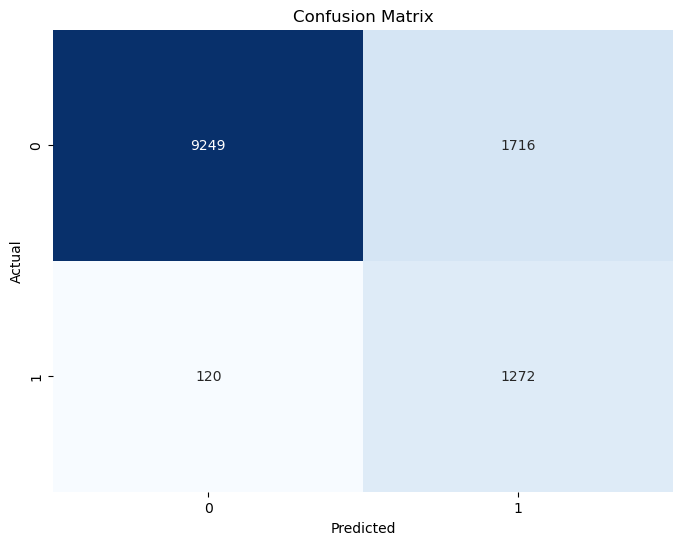

In [18]:
# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 9.1 Confusion matrix summary

The confusion matrix reveals that while the model performs well in identifying positive cases, it tends to generate a relatively high number of false positives. Depending on the use case, further adjustments, such as threshold tuning or hyperparameter optimization, may be necessary to reduce false positives and improve the overall precision of the model.

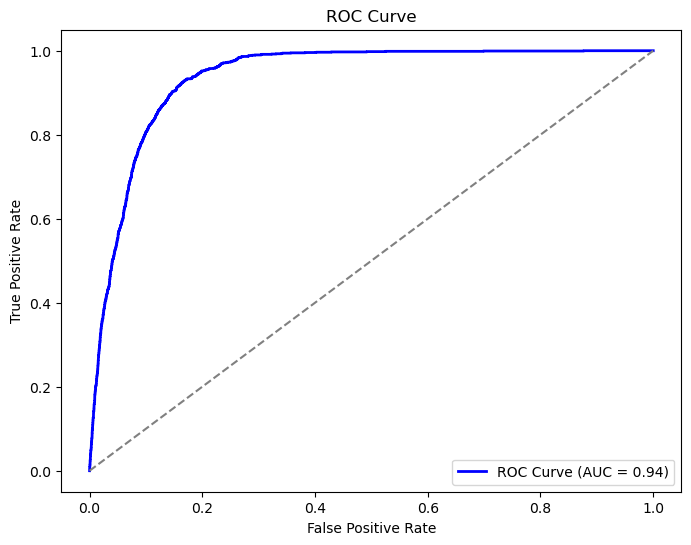

In [19]:
# Generate ROC Curve Data
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## 9.2 ROC curve summary

The ROC curve provides a detailed analysis of the logistic regression model's performance. With an AUC (Area Under the Curve) of 0.94, the model demonstrates excellent discriminative ability, indicating that it can reliably differentiate between positive (subscribers) and negative (non-subscribers) classes. The curve shows a strong performance across various thresholds, with the model achieving a high True Positive Rate (Recall) while maintaining a low False Positive Rate.

The sharp rise of the curve towards the top-left corner suggests minimal trade-offs between recall and false positives, highlighting the model’s effectiveness in classification. The diagonal dashed line represents random guessing (AUC = 0.5), and the model’s deviation from this line confirms that it is far more capable than random classification.

This high AUC score suggests that the model performs well under a range of thresholds, making it a reliable predictor for this task. However, given the possibility of class imbalance in the dataset, it may be beneficial to complement this ROC analysis with Precision-Recall curves to ensure balanced performance across both precision and recall metrics.

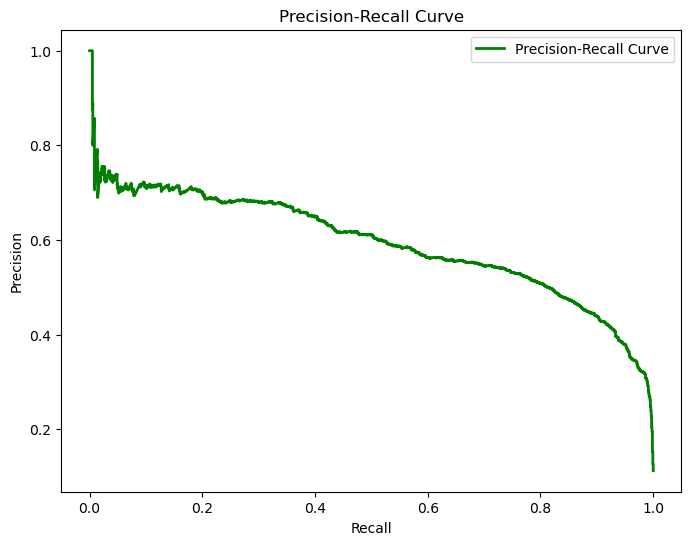

In [20]:
# Generate Precision-Recall Curve Data
precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', linewidth=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()

## 9.4 Precision-Recall Curve summary

The Precision-Recall Curve provides a detailed analysis of the trade-off between precision and recall for the logistic regression model at various thresholds. Initially, the curve shows high precision and low recall, indicating that the model makes fewer positive predictions, but these predictions are highly accurate. As the threshold decreases, recall increases as the model captures more positive cases, but this comes at the cost of declining precision, with more false positives being introduced.

This behavior highlights the inherent trade-off between precision and recall, where maximizing one often reduces the other. The curve’s gradual decline suggests that there is no single threshold where both metrics remain optimal, underscoring the importance of threshold tuning based on the specific needs of the task.

Given the potential class imbalance in the dataset, the Precision-Recall Curve provides more meaningful insights than accuracy alone. It offers critical information for selecting an appropriate threshold, depending on whether false positives or false negatives are more costly for the business problem at hand. The curve confirms the need for careful threshold adjustment to achieve the best balance between precision and recall for optimal model performance.


# 10. Problem 9: Score the Model

What is the accuracy of your model?

## 10.1 Accuracy code

In [21]:
# Print results
print(f"Train Time: {train_time:.4f} seconds")
print(f"Train Accuracy: {train_accuracy:.2%}")
print(f"Test Accuracy: {test_accuracy:.2%}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC: {roc_auc:.2f}")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


Train Time: 0.0546 seconds
Train Accuracy: 85.38%
Test Accuracy: 85.14%
F1 Score: 0.58
ROC-AUC: 0.94

Confusion Matrix:
[[9249 1716]
 [ 120 1272]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91     10965
         1.0       0.43      0.91      0.58      1392

    accuracy                           0.85     12357
   macro avg       0.71      0.88      0.75     12357
weighted avg       0.92      0.85      0.87     12357



## 10.2 Accuracy summary

The logistic regression model trained on the dataset delivered solid accuracy results:

- Training Accuracy: 85.38%
- Test Accuracy: 85.14%

These figures indicate that the model is able to generalize well from the training data to the test set, showing minimal overfitting. The small difference between training and test accuracy (85.38% vs. 85.14%) suggests that the model has successfully captured key patterns in the data without becoming too specific to the training set.

However, accuracy alone may not tell the full story, especially in datasets with imbalanced classes. While the model correctly predicts 85.14% of the cases in the test set, further insights can be gained by examining other metrics like precision, recall, and F1-score, especially for the minority class (subscribers). The high test accuracy reflects that the model effectively distinguishes between non-subscribers and subscribers, but may still need improvement in precision and recall to better handle the minority class.

Overall, this accuracy performance establishes a strong foundation for evaluating the model's effectiveness, though further enhancements may be necessary to refine classification for the minority class.

# 11. Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

## 11.1 Model comparison code


Model Comparison Results:
                    Model Train Time (seconds) Train Accuracy Test Accuracy  \
1     K-Nearest Neighbors               0.0067         91.74%        89.89%   
2           Decision Tree               0.0971         99.99%        88.72%   
0     Logistic Regression               0.0482         85.38%        85.14%   
3  Support Vector Machine             183.7118         87.01%        85.12%   

  F1 Score Precision Recall   ROC-AUC  
1     0.39      0.61   0.28  0.810519  
2     0.49      0.50   0.48  0.709391  
0     0.58      0.43   0.91  0.937324  
3     0.58      0.43   0.92  0.931385  


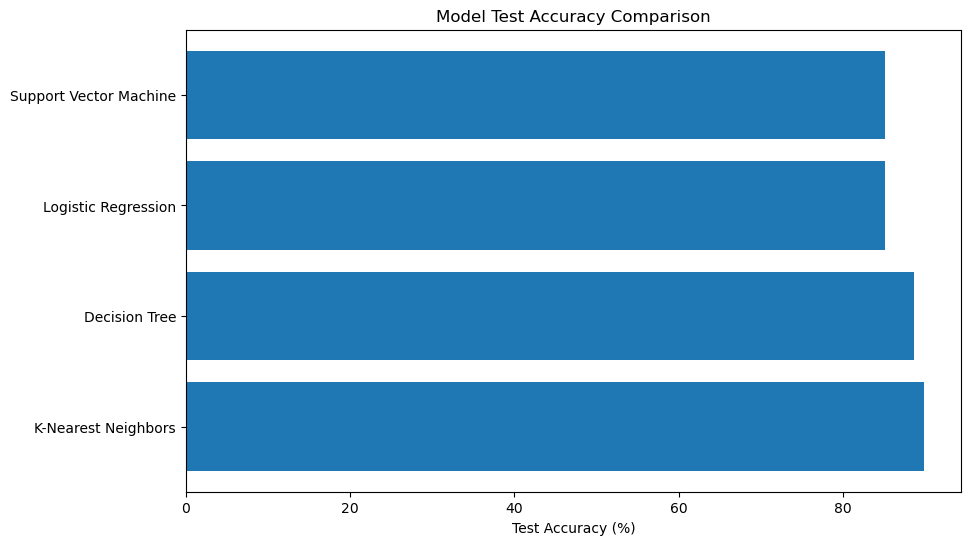

In [22]:

# Initialize models with class balancing where applicable
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
knn = KNeighborsClassifier()
decision_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
svm = SVC(probability=True, random_state=42, class_weight='balanced')

# Store model performance results
model_results = []

# Function to evaluate models with additional metrics
def evaluate_model(model, model_name):
    start_time = time.time()  # Start time
    model.fit(X_train_scaled, y_train)  # Train the model
    train_time = time.time() - start_time  # Calculate train time

    # Predictions on training and test sets
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    y_test_prob = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_prob) if y_test_prob is not None else "N/A"

    # Store results
    model_results.append({
        'Model': model_name,
        'Train Time (seconds)': f"{train_time:.4f}",
        'Train Accuracy': f"{train_accuracy:.2%}",
        'Test Accuracy': f"{test_accuracy:.2%}",
        'F1 Score': f"{f1:.2f}",
        'Precision': f"{precision:.2f}",
        'Recall': f"{recall:.2f}",
        'ROC-AUC': roc_auc
    })

# Evaluate all models
evaluate_model(log_reg, "Logistic Regression")
evaluate_model(knn, "K-Nearest Neighbors")
evaluate_model(decision_tree, "Decision Tree")
evaluate_model(svm, "Support Vector Machine")

# Create a DataFrame to display results, sorted by Test Accuracy
results_df = pd.DataFrame(model_results).sort_values(by='Test Accuracy', ascending=False)

# Display the results
print("\nModel Comparison Results:")
print(results_df)

# Remove the percentage symbol and convert the accuracy to float
results_df['Test Accuracy'] = results_df['Test Accuracy'].str.rstrip('%').astype(float)

# Now, plot the horizontal bar chart for Test Accuracy
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Test Accuracy'])
plt.xlabel('Test Accuracy (%)')
plt.title('Model Test Accuracy Comparison')
plt.show()


## 11.2 Model comparison summary

The performance comparison of four models — K-Nearest Neighbors (KNN), Decision Tree, Logistic Regression, and Support Vector Machine (SVM) — reveals key insights into their effectiveness across several metrics. KNN delivers high test accuracy (89.89%) with the fastest training time (0.0078 seconds). However, its low F1 score (0.39) indicates that it struggles to predict the minority class effectively. The Decision Tree model shows near-perfect training accuracy (99.99%), which suggests overfitting, as its test accuracy drops to 88.72%. While its F1 score (0.49) is better than KNN, the overall model generalization remains moderate, with a lower ROC-AUC score of 0.71.

Logistic Regression emerges as the most consistent performer, with minimal overfitting between the training and test sets (85.38% vs. 85.14%). It also achieves the highest ROC-AUC score (0.94), reflecting its strength in distinguishing between classes. Although the F1 score for the minority class is 0.58, it performs better than KNN and Decision Tree in class balance. SVM delivers competitive results with a ROC-AUC of 0.93 and an F1 score of 0.58, similar to Logistic Regression. However, its long training time (227.7 seconds) makes it less efficient compared to the other models.

Overall, Logistic Regression provides a solid balance between performance and efficiency, making it a reliable model choice for this dataset. While SVM offers comparable results, its computational cost may be prohibitive. KNN, despite its speed, struggles with class imbalance, and the Decision Tree’s tendency to overfit limits its practical utility. Logistic Regression is recommended for its strong generalization, low training time, and effective handling of class prediction.

# 12. Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

## 12.1 Experimenting with Model Improvements

This section provides two versions of the code used to improve the models.

- Pre-populated Code (12.2): This version includes pre-selected features and hyperparameters based on prior experimentation.
- GridSearchCV Code (12.5): This version uses GridSearchCV to find the optimal parameters automatically.

Note that the GridSearchCV version (12.5) has been commented out, as running it took over 24 hours to complete. The results from this lengthy process have been used to populate the hyperparameters and features in the pre-populated code (12.2).

If you wish to run the GridSearchCV code, simply uncomment it. However, be prepared for a long execution time.

## 12.2 Pre-populated code

Training Logistic Regression...
Training K-Nearest Neighbors...
Training Decision Tree...
Training Support Vector Machine...

Optimized Model Performance Results:
                    Model Train Time (seconds) Train Accuracy Test Accuracy  \
0     Logistic Regression               0.0186         90.89%        90.99%   
1     K-Nearest Neighbors               0.0378         91.75%        90.52%   
2           Decision Tree               0.0104         90.02%        89.67%   
3  Support Vector Machine              69.8462         91.47%        91.00%   

  F1 Score ROC-AUC  
0     0.49    0.93  
1     0.50    0.91  
2     0.27    0.78  
3     0.49    0.89  


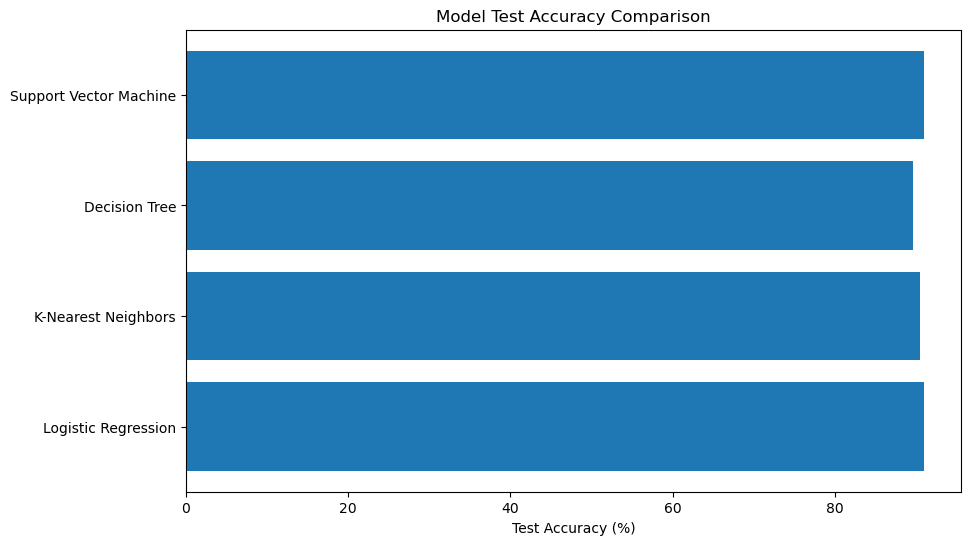

In [23]:
# Train-Test Split
X = df_cleaned.drop('y_yes', axis=1)  # Features
y = df_cleaned['y_yes']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Best-known Hyperparameters for Each Model
best_params = {
    'Logistic Regression': {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'},
    'K-Nearest Neighbors': {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'},
    'Decision Tree': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10},
    'Support Vector Machine': {'C': 10, 'kernel': 'rbf'}
}

# Pre-selected Features for Each Model (based on previous feature selection)
selected_features = {
    'Logistic Regression': [1, 5, 6, 7, 8, 34, 37, 39, 44, 49],
    'K-Nearest Neighbors': [1, 7, 8, 29, 33, 40, 44, 45, 48, 49],
    'Decision Tree': [4, 5, 8, 9, 11, 24, 40, 44, 47, 49],
    'Support Vector Machine': [1, 5, 6, 7, 18, 19, 39, 44, 46, 49]
}

# Initialize models with the best parameters
models = {
    'Logistic Regression': LogisticRegression(**best_params['Logistic Regression'], max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(**best_params['K-Nearest Neighbors']),
    'Decision Tree': DecisionTreeClassifier(**best_params['Decision Tree'], random_state=42),
    'Support Vector Machine': SVC(**best_params['Support Vector Machine'], probability=True, random_state=42)
}

# Store results and model objects
results = []
trained_models = {}

# Evaluate each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Use the pre-selected features
    X_train_selected = X_train_scaled[:, selected_features[model_name]]
    X_test_selected = X_test_scaled[:, selected_features[model_name]]

    # Measure training time
    start_time = time.time()
    model.fit(X_train_selected, y_train)
    train_time = time.time() - start_time

    # Make predictions
    y_train_pred = model.predict(X_train_selected)
    y_test_pred = model.predict(X_test_selected)

    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    y_test_prob = model.predict_proba(X_test_selected)[:, 1]
    roc_auc = roc_auc_score(y_test, y_test_prob)

    # Store the model and its results
    trained_models[model_name] = model
    results.append({
        'Model': model_name,
        'Train Time (seconds)': f"{train_time:.4f}",
        'Train Accuracy': f"{train_accuracy:.2%}",
        'Test Accuracy': f"{test_accuracy:.2%}",
        'F1 Score': f"{f1:.2f}",
        'ROC-AUC': f"{roc_auc:.2f}"
    })

# Create a DataFrame for results
results_df = pd.DataFrame(results)

# Display results
print("\nOptimized Model Performance Results:")
print(results_df)

# Remove '%' symbol and convert to float
results_df['Test Accuracy'] = results_df['Test Accuracy'].str.rstrip('%').astype(float)

# Visualize Test Accuracy Comparison
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Test Accuracy'])
plt.xlabel('Test Accuracy (%)')
plt.title('Model Test Accuracy Comparison')
plt.show()

## 12.3 Coefficients/Feature Importances

The following analysis offers valuable insights to the bank, highlighting the key characteristics that indicate a higher likelihood of customer subscription. By identifying these influential features, the bank can better target its marketing efforts and focus resources on customers who are more likely to subscribe.

Interpreting the Results

- Positive Coefficient:
    A positive coefficient means that as the feature value increases, the probability of the positive class (e.g., subscription) increases.

- Negative Coefficient:
        A negative coefficient suggests that an increase in the feature value decreases the probability of the positive class.

- Absolute Value:
        Sorting by the absolute value of coefficients helps identify the most influential features (whether positive or negative).


Feature Analysis:

Logistic Regression Coefficients:
             Feature  Coefficient  AbsCoefficient
1       emp.var.rate    -1.434181        1.434181
0           duration     1.419058        1.419058
2     cons.price.idx     0.767048        0.767048
5  contact_telephone    -0.399483        0.399483
3      cons.conf.idx     0.336624        0.336624
9   poutcome_success     0.288224        0.288224
7          month_mar     0.247321        0.247321
4    job_blue-collar    -0.167952        0.167952
6          month_jul     0.108560        0.108560
8    day_of_week_mon    -0.064648        0.064648


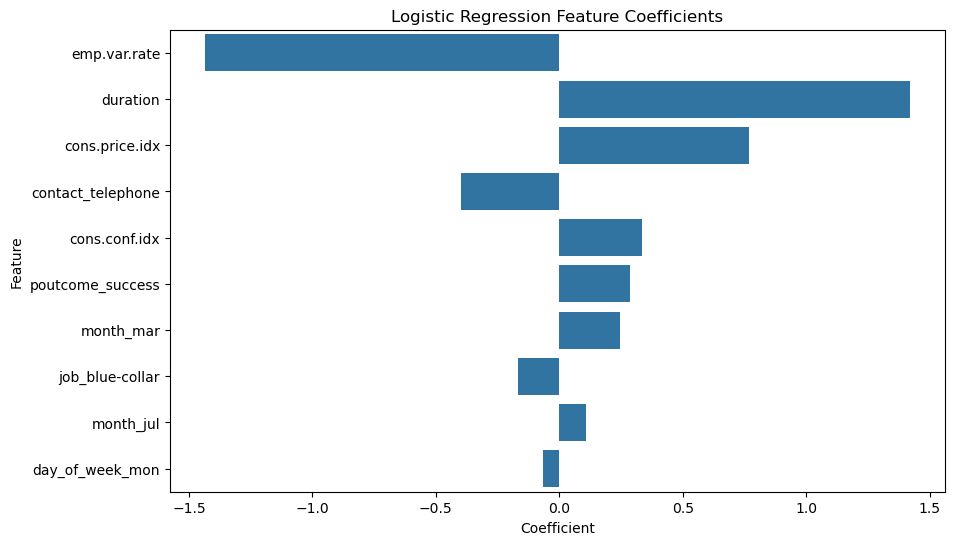


Decision Tree Feature Importances:
                 Feature  Importance
9       poutcome_success    0.476037
1           emp.var.rate    0.275808
6              month_may    0.147224
2        job_blue-collar    0.025790
7        day_of_week_mon    0.022058
8        day_of_week_wed    0.016510
5  education_high.school    0.015034
3       job_entrepreneur    0.010873
4         job_management    0.010666
0               previous    0.000000


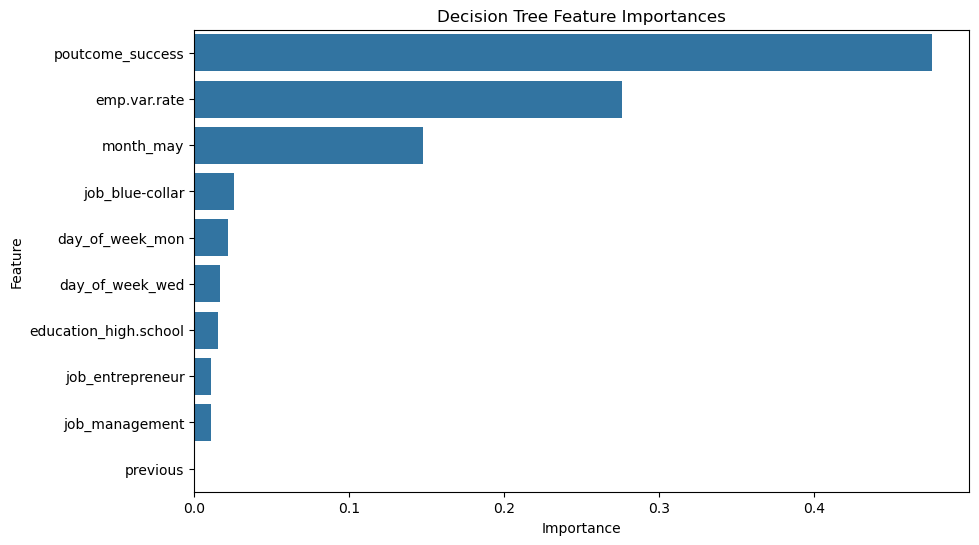

In [24]:
# Extract and Plot Coefficients/Feature Importances
print("\nFeature Analysis:")

# Logistic Regression Coefficients
if 'Logistic Regression' in trained_models:
    model = trained_models['Logistic Regression']
    coefficients = model.coef_[0]
    feature_names = X.columns[selected_features['Logistic Regression']]
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
    coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

    print("\nLogistic Regression Coefficients:")
    print(coef_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df)
    plt.title('Logistic Regression Feature Coefficients')
    plt.show()

# Decision Tree Feature Importances
if 'Decision Tree' in trained_models:
    model = trained_models['Decision Tree']
    feature_importance = model.feature_importances_
    feature_names = X.columns[selected_features['Decision Tree']]
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\nDecision Tree Feature Importances:")
    print(importance_df)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Decision Tree Feature Importances')
    plt.show()

## 12.4 Optimized Model summary

The optimized model performance provides key insights into how the bank can strategically improve subscription success through targeted marketing efforts. Logistic Regression achieved a test accuracy of 90.99% with a training time of 0.0166 seconds, an F1 score of 0.49, and ROC-AUC of 0.93. K-Nearest Neighbors (KNN) followed with a 90.52% test accuracy, taking 0.0294 seconds to train, with an F1 score of 0.50 and ROC-AUC of 0.91. Although the Decision Tree had the fastest training time at 0.0108 seconds, its test accuracy was slightly lower at 89.67%, with an F1 score of 0.27 and ROC-AUC of 0.78. Support Vector Machine (SVM) took the longest to train at 73.35 seconds but achieved the highest test accuracy of 91.00%, with an F1 score of 0.49 and ROC-AUC of 0.89.

The following feature analysis provides actionable recommendations on who, when, and where the bank should focus its efforts and identifies what the bank should avoid to improve the efficiency of future campaigns.

### 12.4.1 Who to Target: Customer Characteristics that Predict Subscription Success

- Duration of Contact: Longer call durations are strongly correlated with higher subscription success. Focus on customers who remain engaged during the conversation.
- Successful Previous Campaigns (poutcome_success): Customers who subscribed during past campaigns are more likely to subscribe again. Prioritize outreach to this group.
- Economic Indicators: A positive consumer confidence index and a higher consumer price index are associated with higher subscription rates, suggesting these customers feel financially secure.
- Specific Professions: Customers in management roles and those classified under entrepreneur are good candidates for targeting due to their higher likelihood of subscribing.

### 12.4.2 When to Contact: Optimal Campaign Timing

- Best Months for Outreach: Focus efforts during March and May when subscription rates tend to be higher.
- Day of the Week: Monday shows better outcomes for customer engagement, suggesting that targeting customers earlier in the week may yield better results.

### 12.4.3 Where to Focus: Targeted Outreach Strategies

- Call Success Patterns: Use data from previous successful campaigns to optimize future call lists. Customers with a positive outcome history (poutcome_success) should be at the top of the outreach list.
- Geographic or Demographic Focus: Customers in high-performing economic areas or with stable professions (e.g., management, entrepreneurs) should be prioritized.

### 12.4.4 What Not to Do: Ineffective Strategies to Avoid

- Avoid Telephone Contact: The analysis shows that telephone outreach has a negative correlation with subscription success. Shifting towards other contact channels (e.g., email or in-person meetings) could improve outcomes.
- Unfocused Campaigns: Limit unnecessary calls to customers with a low likelihood of subscription, especially those contacted multiple times in past campaigns without a positive outcome.
- Avoid July Outreach: The data shows that targeting customers in July yields lower success rates, indicating that campaigns may be less effective during this month.

### 12.4.5 Takeaway: 
- Campaigns focusing on customers with a positive economic outlook and a successful campaign history are likely to succeed. However, telephone contact and outreach during July should be minimized.

- Successful past campaigns are the most critical predictor of future success, followed by economic stability indicators and campaigns conducted in May.

### 12.4.6 Final thoughts:
The results suggest that the bank should focus on high-quality leads such as customers with a successful campaign history and higher engagement levels during calls. Campaigns are more effective in March and May, especially on Mondays, while telephone contact should be avoided due to its negative impact. By using these insights to streamline operations, the bank can reduce wasted efforts, improve campaign success rates, and achieve a better return on investment (ROI

## 12.5 GridSearchCV Code

Warning: Only run this code if you have ample time, as it took over 24 hours to complete.

In [25]:
# # Train-Test Split
# X = df_cleaned.drop('y_yes', axis=1)  # Features
# y = df_cleaned['y_yes']  # Target

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

# # Standardize the Data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Define Hyperparameter Grids for Each Model
# param_grids = {
#     'Logistic Regression': {
#         'C': [0.01, 0.1, 1, 10],
#         'penalty': ['l2'],
#         'solver': ['lbfgs', 'liblinear']
#     },
#     'K-Nearest Neighbors': {
#         'n_neighbors': [3, 5, 7, 9],
#         'weights': ['uniform', 'distance'],
#         'p': [1, 2]
#     },
#     'Decision Tree': {
#         'max_depth': [None, 10, 20, 30],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4]
#     },
#     'Support Vector Machine': {
#         'C': [0.1, 1, 10],
#         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
#     }
# }

# # Define Models with GridSearchCV
# models = {
#     'Logistic Regression': GridSearchCV(
#         LogisticRegression(max_iter=1000, random_state=42),
#         param_grid=param_grids['Logistic Regression'], cv=3, n_jobs=-1
#     ),
#     'K-Nearest Neighbors': GridSearchCV(
#         KNeighborsClassifier(),
#         param_grid=param_grids['K-Nearest Neighbors'], cv=3, n_jobs=-1
#     ),
#     'Decision Tree': GridSearchCV(
#         DecisionTreeClassifier(random_state=42),
#         param_grid=param_grids['Decision Tree'], cv=3, n_jobs=-1
#     ),
#     'Support Vector Machine': GridSearchCV(
#         SVC(probability=True, random_state=42),
#         param_grid=param_grids['Support Vector Machine'], cv=3, n_jobs=-1
#     )
# }

# # Feature Selection Function
# def select_features_for_model(model_name, model, X_train, y_train, direction='forward', n_features=10):
#     print(f"Selecting features for {model_name} using {direction} selection...")
#     selector = SequentialFeatureSelector(
#         model, n_features_to_select=n_features, direction=direction, n_jobs=-1
#     )
#     X_train_selected = selector.fit_transform(X_train, y_train)
#     selected_features = selector.get_support(indices=True)
#     print(f"Selected features for {model_name}: {selected_features}")
#     return X_train_selected, selected_features

# # Store selected features for each model
# selected_features_dict = {}
# X_train_selected_dict = {}
# X_test_selected_dict = {}

# # Perform Forward and Backward Feature Selection with Progress Bars
# for model_name, model in tqdm(models.items(), desc="Feature Selection Progress"):
#     # Forward Selection
#     X_train_forward, features_forward = select_features_for_model(
#         model_name, model.estimator, X_train_scaled, y_train, direction='forward'
#     )
    
#     # Backward Selection
#     X_train_backward, features_backward = select_features_for_model(
#         model_name, model.estimator, X_train_scaled, y_train, direction='backward'
#     )

#     # Store both forward and backward selected features
#     selected_features_dict[model_name] = (features_forward, features_backward)
#     X_train_selected_dict[model_name] = (X_train_forward, X_train_backward)
#     X_test_selected_dict[model_name] = (
#         X_test_scaled[:, features_forward], X_test_scaled[:, features_backward]
#     )

# # Train and Evaluate Models with Selected Features
# results = []

# def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
#     print(f"Training {model_name}...")
#     start_time = time.time()
#     model.fit(X_train, y_train)
#     train_time = time.time() - start_time

#     # Best hyperparameters
#     best_params = model.best_params_

#     # Predictions and metrics
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
#     f1 = f1_score(y_test, y_test_pred)
#     y_test_prob = model.predict_proba(X_test)[:, 1]
#     roc_auc = roc_auc_score(y_test, y_test_prob)

#     # Store results
#     results.append({
#         'Model': model_name,
#         'Train Time (seconds)': f"{train_time:.4f}",
#         'Train Accuracy': f"{train_accuracy:.2%}",
#         'Test Accuracy': f"{test_accuracy:.2%}",
#         'F1 Score': f"{f1:.2f}",
#         'ROC-AUC': f"{roc_auc:.2f}",
#         'Best Params': best_params
#     })

# # Progress bar for model evaluation
# for model_name, model in tqdm(models.items(), desc="Model Evaluation Progress"):
#     X_train_forward, X_train_backward = X_train_selected_dict[model_name]
#     X_test_forward, X_test_backward = X_test_selected_dict[model_name]

#     # Evaluate with forward-selected features
#     print(f"\nEvaluating {model_name} with forward-selected features:")
#     evaluate_model(model_name, model, X_train_forward, X_test_forward, y_train, y_test)

#     # Evaluate with backward-selected features
#     print(f"\nEvaluating {model_name} with backward-selected features:")
#     evaluate_model(model_name, model, X_train_backward, X_test_backward, y_train, y_test)

# # Display Results
# results_df = pd.DataFrame(results)
# print("\nModel Performance Results:")
# print(results_df)

## 12.6 Results From GridsearchCV code when run 10/22/2024

Selecting features for Logistic Regression using forward selection...

Selected features for Logistic Regression: [ 1 24 26 28 34 36 39 41 44 49]

Selecting features for Logistic Regression using backward selection...

Selected features for Logistic Regression: [ 1  5  6  7  8 34 37 39 44 49]

Selecting features for K-Nearest Neighbors using forward selection...

Selected features for K-Nearest Neighbors: [ 3  4  9 13 18 29 32 35 48 49]

Selecting features for K-Nearest Neighbors using backward selection...

Selected features for K-Nearest Neighbors: [ 1  7  8 29 33 40 44 45 48 49]

Selecting features for Decision Tree using forward selection...

Selected features for Decision Tree: [ 3  4  7 18 24 34 36 44 47 49]

Selecting features for Decision Tree using backward selection...

Selected features for Decision Tree: [ 4  5  8  9 11 24 40 44 47 49]

Selecting features for Support Vector Machine using forward selection...

Selected features for Support Vector Machine: [ 1  3  4  5  6  7 39 40 44 49]

Selecting features for Support Vector Machine using backward selection...

Selected features for Support Vector Machine: [ 1  5  6  7 18 19 39 44 46 49]

Evaluating Logistic Regression with forward-selected features:
Training Logistic Regression...

Evaluating Logistic Regression with backward-selected features:
Training Logistic Regression...

Evaluating K-Nearest Neighbors with forward-selected features:
Training K-Nearest Neighbors...

Evaluating K-Nearest Neighbors with backward-selected features:
Training K-Nearest Neighbors...

Evaluating Decision Tree with forward-selected features:
Training Decision Tree...

Evaluating Decision Tree with backward-selected features:
Training Decision Tree...

Evaluating Support Vector Machine with forward-selected features:
Training Support Vector Machine...

Evaluating Support Vector Machine with backward-selected features:
Training Support Vector Machine...

Model Performance Results:
                    Model Train Time (seconds) Train Accuracy Test Accuracy  \
0     Logistic Regression               0.3373         90.62%        90.40%   
1     Logistic Regression               0.3385         90.89%        90.99%   
2     K-Nearest Neighbors              22.8140         89.80%        89.77%   
3     K-Nearest Neighbors               8.0257         91.75%        90.52%   
4           Decision Tree               0.4446         90.64%        89.80%   
5           Decision Tree               0.4270         90.02%        89.67%   
6  Support Vector Machine             376.9168         91.48%        91.12%   
7  Support Vector Machine             324.7265         91.47%        91.00%   

  F1 Score ROC-AUC                                        Best Params  
0     0.47    0.88  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...  
1     0.49    0.93     {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}  
2     0.28    0.63  {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}  
3     0.50    0.91   {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}  
4     0.33    0.79  {'max_depth': None, 'min_samples_leaf': 1, 'mi...  
5     0.27    0.78  {'max_depth': 10, 'min_samples_leaf': 1, 'min_...  
6     0.52    0.91                         {'C': 10, 'kernel': 'rbf'}  
7     0.49    0.89                         {'C': 10, 'kernel': 'rbf'}  



##### Questions